# Data Augmentation

This notebook implements data augmentation for seismic signals. For each original signal, two augmented versions are generated using:

1. Amplitude modulation with large window (2000 samples)
2. Time shift (15%) + soft noise (4%)

The goal is to triple the dataset while maintaining important characteristics of seismic signals.

## Key Components:

- **amplitude_modulation**: Applies time-varying amplitude modulation
- **time_shift**: Shifts the signal in time while preserving P-arrival
- **add_noise**: Adds controlled Gaussian noise
- **process_all_files**: Main function to process and augment all files

## Data Organization:

- Original data → training/
- Augmented data → training_augmented/
- Validation split → training_augmented/val/
- Training split → training_augmented/train/
- Final augmented → training_augmented/augmented/

In [ ]:
# Import required libraries
import numpy as np
from scipy import signal
import pandas as pd
import os
from obspy import read
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split
import tqdm

# Define paths for data organization
train_data_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training'
testing_data_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/testing'
train_csv_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/raw/VT_P_training.csv'
augmented_data_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented'
val_data_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/val'
train_augment_data_path = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/train'
train_augment_data_path_2 = '/mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/augmented'
# Crear directorio para datos aumentados si no existe
if not os.path.exists(augmented_data_path):
    os.makedirs(augmented_data_path)

# Leer CSV con tiempos de llegada
df = pd.read_csv(train_csv_path) 

## Data Augmentation Functions

Core functions for implementing different augmentation techniques:

1. **amplitude_modulation**: Modulates signal amplitude using windows
2. **time_shift**: Applies controlled temporal shifts
3. **add_noise**: Adds calibrated Gaussian noise
4. **augment_seismic_data**: Combines techniques to generate augmented signals

In [ ]:
def amplitude_modulation(signal_data, window_size=2000):
    """Applies time-varying amplitude modulation.
    Args:
        signal_data: Original signal
        window_size: Window size for modulation
    Returns:
        array: Modulated signal"""
    envelope = np.ones_like(signal_data)
    num_windows = len(signal_data) // window_size
    for i in range(num_windows):
        start = i * window_size
        end = start + window_size
        envelope[start:end] *= np.random.uniform(0.8, 1.2)
    # Smooth transitions between windows using scipy.signal
    envelope = signal.savgol_filter(envelope, window_length=501, polyorder=3)
    return signal_data * envelope

def time_shift(signal_data, sample_rate, p_arrival_time, shift_range=0.15):
    """Shifts the signal in time while preserving the P-arrival time.
    Args:
        signal_data: Original signal
        sample_rate: Sampling rate
        p_arrival_time: P-arrival time in seconds
        shift_range: Maximum shift range as a fraction of the length
    Returns:
        tuple: (shifted signal, new P-arrival time)"""
    # Convert P-arrival time to samples
    p_sample = int(p_arrival_time * sample_rate)
    
    # Calculate the maximum allowed shift
    max_shift = int(len(signal_data) * shift_range)
    
    # Generate a random shift that keeps the P-arrival time within the signal
    min_shift = -min(p_sample, max_shift)  # Do not shift beyond the start
    max_shift = min(len(signal_data) - p_sample, max_shift)  # Do not shift beyond the end
    shift = int(np.random.uniform(min_shift, max_shift))
    
    # Apply the shift
    shifted_signal = np.roll(signal_data, shift)
    new_p_time = p_arrival_time + (shift / sample_rate)
    
    return shifted_signal, new_p_time

def add_noise(signal_data, noise_level=0.02):
    """Adds Gaussian noise to the signal.
    Args:
        signal_data: Original signal
        noise_level: Noise level (proportion of the standard deviation of the signal)
    Returns:
        array: Signal with noise"""
    noise = np.random.normal(0, noise_level * np.std(signal_data), len(signal_data))
    return signal_data + noise

def augment_seismic_data(signal_data, sample_rate, p_arrival_time):
    """Applies selected data augmentation techniques to the seismic signal.
    Args:
        signal_data: Original seismic signal
        sample_rate: Sampling rate
        p_arrival_time: P-arrival time in seconds
    Returns:
        tuple: (augmented signals, new arrival times)"""
    augmented_signals = []
    augmented_arrivals = []
    
    # 1. Amplitude modulation with large window and smoothing
    signal_amp = amplitude_modulation(signal_data.copy())
    augmented_signals.append(signal_amp)
    augmented_arrivals.append(p_arrival_time)
    
    # 2. Time shift + soft noise
    signal_shifted, new_p_time = time_shift(signal_data.copy(), sample_rate, p_arrival_time)
    signal_shifted = add_noise(signal_shifted)
    augmented_signals.append(signal_shifted)
    augmented_arrivals.append(new_p_time)
    
    return np.array(augmented_signals), np.array(augmented_arrivals)

In [ ]:
def get_relative_p_time(tr, absolute_p_time):
    """Converts the absolute P-arrival time to relative time within the signal.
    Args:
        tr: Trace object from ObsPy
        absolute_p_time: Absolute P-arrival time in seconds
    Returns:
        float: Relative P-arrival time in seconds"""
    start_time = tr.stats.starttime.timestamp
    return absolute_p_time - start_time

def augment_single_file(mseed_file, absolute_p_time):
    """Applies data augmentation to a seismic file and saves the augmented versions.
    Args:
        mseed_file: Name of the MSEED file to augment
        absolute_p_time: Absolute P-arrival time in seconds
    Returns:
        int: Number of augmented signals generated"""
    # Read the original signal
    file_path = os.path.join(train_data_path, mseed_file)
    st = read(file_path)
    tr = st[0]
    
    # Convert absolute P-arrival time to relative
    relative_p_time = get_relative_p_time(tr, absolute_p_time)
    
    # Generate augmented signals
    augmented_signals, augmented_arrivals = augment_seismic_data(
        tr.data,
        tr.stats.sampling_rate,
        relative_p_time
    )

    # Save each augmented signal
    for i, (aug_signal, aug_arrival) in enumerate(zip(augmented_signals, augmented_arrivals)):
        aug_st = st.copy()
        aug_st[0].data = aug_signal
        
        base_name = os.path.splitext(mseed_file)[0]
        aug_filename = f"{base_name}_aug{i+1}.mseed"
        # TODO: hay que cambiar esto para que reciva el directiorio de salida
        output_path = os.path.join(train_augment_data_path_2, aug_filename)
        
        aug_st.write(output_path, format='MSEED')
    
    return len(augmented_signals)

In [ ]:
def plot_augmentation_comparison(mseed_file):
    """Visualizes the original signal and its two augmented versions.
    Args:
        mseed_file: Name of the MSEED file to analyze"""
    # Read original signal
    file_path = os.path.join(train_data_path, mseed_file)
    st = read(file_path)
    tr = st[0]
    
    # Get and convert P-arrival time
    file_id = int(mseed_file.split('.')[0])
    row = df[df['archivo'] == file_id]
    if row.empty:
        print(f"No se encontró el tiempo P para {mseed_file}")
        return
        
    p_time = row.iloc[0]['lec_p']
    relative_p_time = get_relative_p_time(tr, p_time)
    
    # Generate augmented signals
    augmented_signals, augmented_arrivals = augment_seismic_data(
        tr.data, tr.stats.sampling_rate, relative_p_time)

    # Create time vector
    times = np.arange(len(tr.data)) / tr.stats.sampling_rate

    # Adjust the visualization range around the P-arrival time
    window = 50  # seconds before and after the P-arrival time
    start_idx = max(0, int((relative_p_time - window) * tr.stats.sampling_rate))
    end_idx = min(len(times) - 1, int((relative_p_time + window) * tr.stats.sampling_rate))

    # Configure subplots with more height for better visualization
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
    fig.suptitle(f'Comparación de señales - {mseed_file}\nVentana de ±50 segundos alrededor del tiempo P', y=0.95)

    # Plot signals with zoom around the P-arrival time
    ax1.plot(times[start_idx:end_idx+1], tr.data[start_idx:end_idx+1], 'b-', label='Original')
    ax1.axvline(x=relative_p_time, color='r', linestyle='--', label='Llegada P')
    ax1.set_title('Señal Original')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(times[start_idx:end_idx+1], augmented_signals[0][start_idx:end_idx+1], 'g-', 
             label='Modulación de amplitud')
    ax2.axvline(x=augmented_arrivals[0], color='r', linestyle='--', label='Llegada P')
    ax2.set_title('Aumentada: Modulación de amplitud')
    ax2.grid(True)
    ax2.legend()

    ax3.plot(times[start_idx:end_idx+1], augmented_signals[1][start_idx:end_idx+1], 'm-', 
             label='Desplazamiento + ruido')
    ax3.axvline(x=augmented_arrivals[1], color='r', linestyle='--', label='Llegada P')
    ax3.set_title('Aumentada: Desplazamiento + ruido')
    ax3.grid(True)
    ax3.legend()

    for ax in (ax1, ax2, ax3):
        ax.set_xlabel('Tiempo (s)')
        ax.set_ylabel('Amplitud')

    plt.tight_layout()
    plt.show()

    # Imprimir estadísticas e información del desplazamiento
    print("\nEstadísticas de las señales:")
    print("Original:")
    print(f"  Media: {np.mean(tr.data):.3f}")
    print(f"  Desviación estándar: {np.std(tr.data):.3f}")
    print(f"  Tiempo P: {relative_p_time:.2f} s")
    print("\nModulación de amplitud:")
    print(f"  Media: {np.mean(augmented_signals[0]):.3f}")
    print(f"  Desviación estándar: {np.std(augmented_signals[0]):.3f}")
    print(f"  Tiempo P: {augmented_arrivals[0]:.2f} s")
    print("\nDesplazamiento + ruido:")
    print(f"  Media: {np.mean(augmented_signals[1]):.3f}")
    print(f"  Desviación estándar: {np.std(augmented_signals[1]):.3f}")
    print(f"  Tiempo P: {augmented_arrivals[1]:.2f} s")
    print(f"  Desplazamiento: {(augmented_arrivals[1] - relative_p_time):.2f} s")
    
    # Información sobre el rango de tiempo mostrado
    print(f"\nRango de tiempo mostrado: {times[start_idx]:.1f}s - {times[end_idx]:.1f}s")
    print(f"Duración total mostrada: {(times[end_idx] - times[start_idx]):.1f}s")

Procesando archivo: 01061214.mseed
Tiempo de llegada de onda P relativo: 30.90 segundos


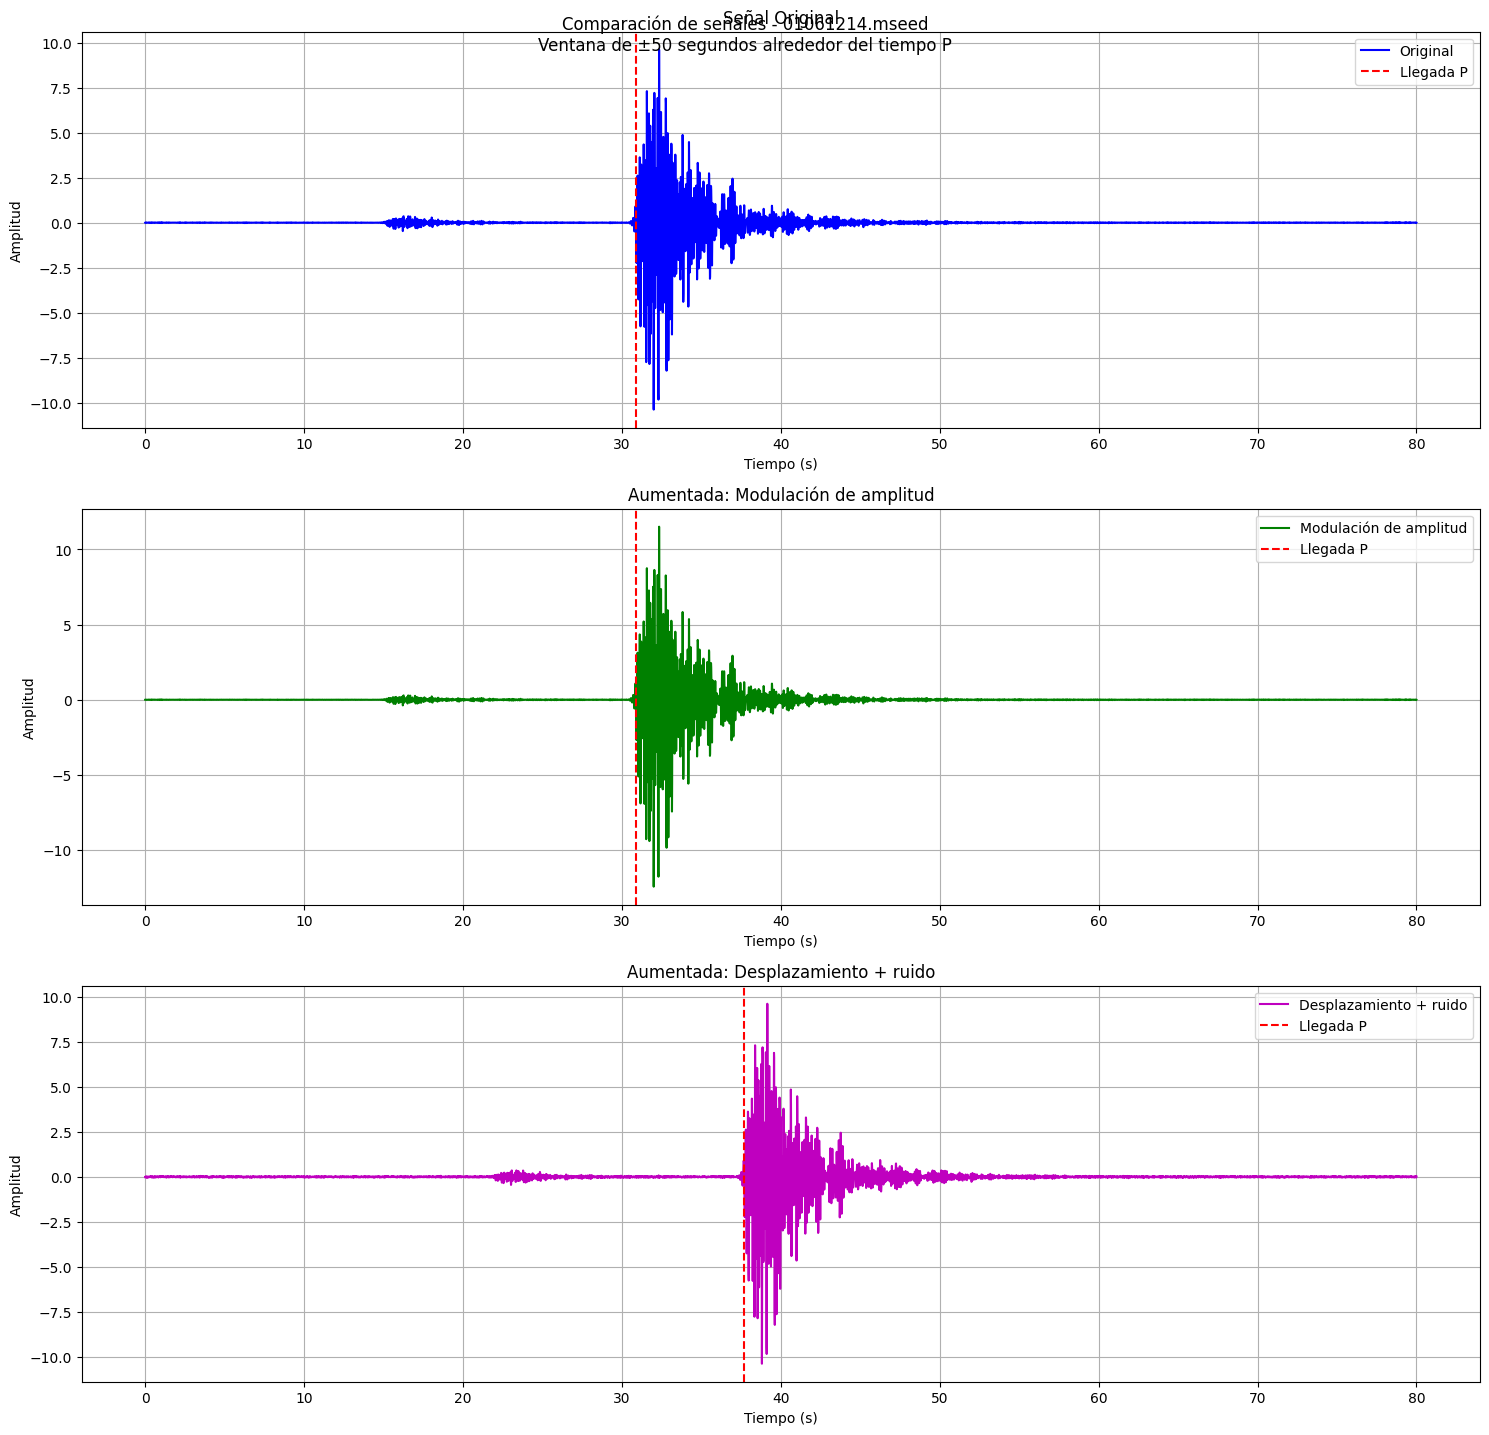


Estadísticas de las señales:
Original:
  Media: 0.000
  Desviación estándar: 0.734
  Tiempo P: 30.90 s

Modulación de amplitud:
  Media: 0.000
  Desviación estándar: 0.878
  Tiempo P: 30.90 s

Desplazamiento + ruido:
  Media: -0.000
  Desviación estándar: 0.734
  Tiempo P: 37.71 s
  Desplazamiento: 6.81 s

Rango de tiempo mostrado: 0.0s - 80.0s
Duración total mostrada: 80.0s

Creadas 2 versiones aumentadas


In [ ]:
# Probar con un archivo de ejemplo
example_file = '01061214.mseed'
example_row = df[df['archivo'] == int(example_file[:8])]

# aplicar data augmented a todos los arhivos y guardar el tiempo de llegada de cada archivo en csv 
if not example_row.empty:
    p_time = example_row.iloc[0]['lec_p']
    print(f"Procesando archivo: {example_file}")
    
    # Leer la señal para obtener el tiempo relativo
    st = read(os.path.join(train_data_path, example_file))
    relative_p_time = get_relative_p_time(st[0], p_time)
    print(f"Tiempo de llegada de onda P relativo: {relative_p_time:.2f} segundos")
    
    # Generar y visualizar las señales aumentadas
    plot_augmentation_comparison(example_file)
    
    # Guardar las señales aumentadas
    num_augmented = augment_single_file(example_file, p_time)
    print(f"\nCreadas {num_augmented} versiones aumentadas")
else:
    print("Archivo no encontrado en el CSV")

In [15]:
# function to move the files 

files = os.listdir(train_data_path)

def copy_files(df, source_path, dest_path):
    """
    Move files from source_path to dest_path based on the filenames in the dataframe.	
    """
    for index, row in df.iterrows():
        filename = row['filename']
        source_file = os.path.join(source_path, filename + '.mseed')
        dest_file = os.path.join(dest_path, filename + '.mseed')
        if os.path.exists(source_file):
            shutil.copy2(source_file, dest_file)
            print(f'Moved {source_file} to {dest_file}')
        else:
            print(f'File {source_file} does not exist')

df = pd.DataFrame(files, columns=['filename'])
df['filename'] = df['filename'].str.replace('.mseed', '') 
train_set, test_set = train_test_split(df, test_size=0.16, random_state=42)


In [ ]:
# move val files 
# copy_files(test_set, train_data_path, val_data_path)

# move train files 
copy_files(train_set, train_data_path, train_augment_data_path)


In [29]:
files_val = os.listdir(val_data_path)
print(f"Total files in val_data_path: {len(files_val)}")
files_training = os.listdir(train_data_path)
print(f"Total files in train_data_path: {len(files_training)}")
files_testing = os.listdir(testing_data_path)
print(f"Total files in augmented_data_path: {len(files_testing)}")
files_augmented = os.listdir(train_augment_data_path)
print(f"Total files in augmented_data_path: {len(files_augmented)}")

Total files in val_data_path: 317
Total files in train_data_path: 1980
Total files in augmented_data_path: 496
Total files in augmented_data_path: 1663


In [ ]:
files_arrival_times = os.listdir(train_augment_data_path_2)
print(f"Total files in augmented_data_path: {len(files_arrival_times)}")

# view one file to see the arrival time


In [11]:
def process_all_files():
    # Prepare dataframe to store arrival times
    columns = ['original_file', 'augmented_file', 'arrival_time', 'augmentation_type']
    arrival_times_df = pd.DataFrame(columns=columns)

    # Get list of files in training directory
    train_files = [f for f in os.listdir(train_augment_data_path) if f.endswith('.mseed')]

    print(f"Processing {len(train_files)} files...")

    for mseed_file in tqdm(train_files):
        # Get original file ID and lookup P arrival time
        file_id = int(mseed_file.split('.')[0])
        row = df[df['archivo'] == file_id]

        if not row.empty:
            p_time = row.iloc[0]['lec_p']
            
            # Read original signal
            st = read(os.path.join(train_augment_data_path, mseed_file))
            relative_p_time = get_relative_p_time(st[0], p_time)
            
            # Store original file info
            base_name = os.path.splitext(mseed_file)[0]
            arrival_times_df = pd.concat([arrival_times_df, pd.DataFrame([{
                'original_file': mseed_file,
                'augmented_file': mseed_file,
                'arrival_time': relative_p_time,
                'augmentation_type': 'original'
            }])], ignore_index=True)
            
            # Generate augmented signals with their respective arrival times
            augmented_signals, augmented_arrivals = augment_seismic_data(
                st[0].data,
                st[0].stats.sampling_rate,
                relative_p_time
            )
            
            # Generate and save augmented signals
            for i, (aug_signal, aug_arrival) in enumerate(zip(augmented_signals, augmented_arrivals)):
                aug_st = st.copy()
                aug_st[0].data = aug_signal
                aug_filename = f"{base_name}_aug{i+1}.mseed"
                output_path = os.path.join(train_augment_data_path_2, aug_filename)
                aug_st.write(output_path, format='MSEED')
                
                aug_type = 'amplitude_modulation' if i == 0 else 'time_shift_noise'
                arrival_times_df = pd.concat([arrival_times_df, pd.DataFrame([{
                    'original_file': mseed_file,
                    'augmented_file': aug_filename,
                    'arrival_time': aug_arrival,  # Using the actual augmented arrival time
                    'augmentation_type': aug_type
                }])], ignore_index=True)

    # Save arrival times to CSV
    csv_path = os.path.join(augmented_data_path, 'arrival_times.csv')
    arrival_times_df.to_csv(csv_path, index=False)
    print(f"\nArrival times saved to {csv_path}")
    return arrival_times_df

# Call the function to process all files
arrival_times_df = process_all_files()
# Print the first few rows of the DataFrame
print(arrival_times_df.head())



Processing 1663 files...


  0%|          | 0/1663 [00:00<?, ?it/s]/tmp/ipykernel_2593/2942974162.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  arrival_times_df = pd.concat([arrival_times_df, pd.DataFrame([{
  0%|          | 1/1663 [00:00<03:15,  8.49it/s]/tmp/ipykernel_2593/2942974162.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  arrival_times_df = pd.concat([arrival_times_df, pd.DataFrame([{
100%|██████████| 1663/1663 [00:57<00:00, 29.01it/s] 




Arrival times saved to /mnt/c/Users/Usuario/Documents/Studies/GicoProject/SeismicWaves/data/procesed/used_data/training_augmented/arrival_times.csv
    original_file       augmented_file  arrival_time     augmentation_type
0  01010056.mseed       01010056.mseed          30.6              original
1  01010056.mseed  01010056_aug1.mseed          30.6  amplitude_modulation
2  01010056.mseed  01010056_aug2.mseed          21.0      time_shift_noise
3  01010332.mseed       01010332.mseed          30.1              original
4  01010332.mseed  01010332_aug1.mseed          30.1  amplitude_modulation


In [ ]:
# copy original files to augmented data 
copy_files(train_set, train_augment_data_path, train_augment_data_path_2)


In [18]:
filses_augmented = os.listdir(train_augment_data_path_2)
print(f"Total files in augmented_data_path: {len(filses_augmented)}")
files_training = os.listdir(train_augment_data_path)
print(f"Total files in train_augment_data_path: {len(files_training)}")

Total files in augmented_data_path: 4989
Total files in train_augment_data_path: 1663


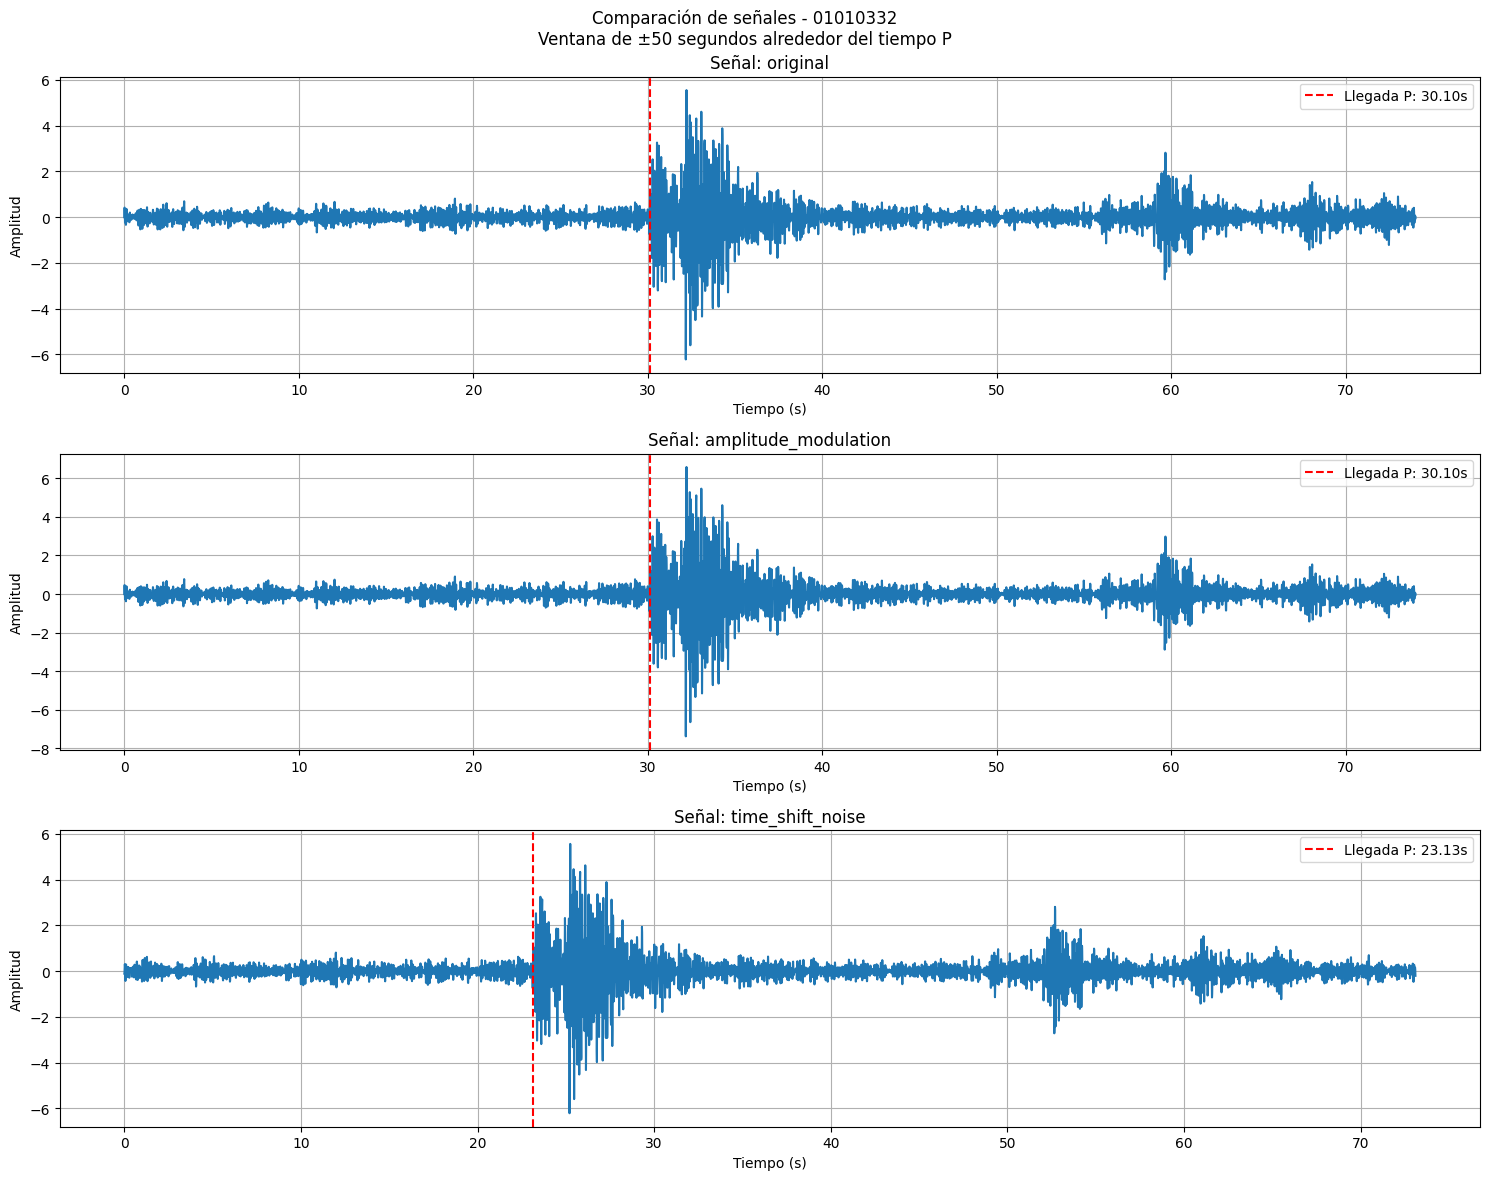

In [20]:
def plot_three_signals(base_filename):
    # Get arrival times from DataFrame
    signals_info = arrival_times_df[arrival_times_df['original_file'] == base_filename + '.mseed']
    
    if len(signals_info) != 3:
        print(f"No se encontraron las tres versiones de la señal para {base_filename}")
        return
    
    # Configurar subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle(f'Comparación de señales - {base_filename}\nVentana de ±50 segundos alrededor del tiempo P')
    
    # Definir ventana de visualización
    window = 50  # segundos antes y después del tiempo P
    
    for idx, (_, row) in enumerate(signals_info.iterrows()):
        # Leer la señal
        file_path = os.path.join(train_augment_data_path_2, row['augmented_file'])
        st = read(file_path)
        tr = st[0]
        
        # Crear vector de tiempo
        times = np.arange(len(tr.data)) / tr.stats.sampling_rate
        
        # Ajustar ventana alrededor del tiempo P
        p_time = row['arrival_time']
        start_idx = max(0, int((p_time - window) * tr.stats.sampling_rate))
        end_idx = min(len(times), int((p_time + window) * tr.stats.sampling_rate))
        
        # Seleccionar el subplot correspondiente
        ax = [ax1, ax2, ax3][idx]
        
        # Graficar señal
        ax.plot(times[start_idx:end_idx], tr.data[start_idx:end_idx], '-')
        ax.axvline(x=p_time, color='r', linestyle='--', label=f'Llegada P: {p_time:.2f}s')
        ax.set_title(f'Señal: {row["augmentation_type"]}')
        ax.grid(True)
        ax.legend()
        ax.set_xlabel('Tiempo (s)')
        ax.set_ylabel('Amplitud')
    
    plt.tight_layout()
    plt.show()

# Graficar las señales para el archivo 01010056
plot_three_signals('01010332')

>Note: I will use this functions to automate the training becouse i will use cross validation and k-folds to tune hyperparameters and chose the best model using diferent data, this is one example of how works, t rest of the folds will be stores in google drive, the part of training will be in google colab, and make me easier store there the data, the zip will be added when i finish the train de model.